# Urban Sound Classification - Part 2

At the end of the previous post, I just realised that the sound files in data might have different sampling rates, bit depths, number of channels from file to file. First, let me extract this information from each sound file and see how the distribution looks like.

## Sound Data Format Investigation

I haven't properly explained this in my previous post, but in a WAVE file, there's not only sampled sound data but also all the information about the data format. Below picture shows what kind of information is available in a WAVE file.

![title](urbansound_image/wave_file_format.png)

In addition to path_class (to build a full path name from each file name) function I defined in the previous post, I will add one more function wav_fmt_parser just to extract three types of information I need from each WAVE file, number of channels, sampling rate, bit_depth.

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("UrbanSound8K/metadata/UrbanSound8K.csv")

In [2]:
import os
import struct
from scipy.io import wavfile as wav
import matplotlib.pyplot as plt
import IPython.display as ipd

def path_class(filename):
    excerpt = data[data['slice_file_name'] == filename]
    path_name = os.path.join('UrbanSound8K/audio', 'fold'+str(excerpt.fold.values[0]), filename)
    return path_name, excerpt['class'].values[0]

def wav_plotter(full_path, class_label):   
    rate, wav_sample = wav.read(full_path)
    wave_file = open(full_path,"rb")
    riff_fmt = wave_file.read(36)
    bit_depth_string = riff_fmt[-2:]
    bit_depth = struct.unpack("H",bit_depth_string)[0]
    print('sampling rate: ',rate,'Hz')
    print('bit depth: ',bit_depth)
    print('number of channels: ',wav_sample.shape[1])
    print('duration: ',wav_sample.shape[0]/rate,' second')
    print('number of samples: ',len(wav_sample))
    print('class: ',class_label)
    plt.figure(figsize=(12, 4))
    plt.plot(wav_sample) 
    return ipd.Audio(full_path)

In [3]:
def wav_fmt_parser(file_name):
    full_path, _ = path_class(file_name)
    wave_file = open(full_path,"rb")
    riff_fmt = wave_file.read(36)
    n_channels_string = riff_fmt[22:24]
    n_channels = struct.unpack("H",n_channels_string)[0]
    s_rate_string = riff_fmt[24:28]
    s_rate = struct.unpack("I",s_rate_string)[0]
    bit_depth_string = riff_fmt[-2:]
    bit_depth = struct.unpack("H",bit_depth_string)[0]
    return (n_channels,s_rate,bit_depth)

Now we can use this wav_fmt_parser function to add additional information to our data frame to see what kind of different data types exist in our dataset, and how they are distributed.

In [4]:
wav_fmt_data = [wav_fmt_parser(i) for i in data.slice_file_name]

In [5]:
data[['n_channels','sampling_rate','bit_depth']] = pd.DataFrame(wav_fmt_data)
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,n_channels,sampling_rate,bit_depth
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,2,44100,16
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,2,44100,16
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,2,44100,16
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,2,44100,16
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,2,44100,16


In [6]:
data.sampling_rate.value_counts()

44100     5370
48000     2502
96000      610
24000       82
16000       45
22050       44
11025       39
192000      17
8000        12
11024        7
32000        4
Name: sampling_rate, dtype: int64

In [7]:
data.n_channels.value_counts()

2    7993
1     739
Name: n_channels, dtype: int64

In [8]:
data.bit_depth.value_counts()

16    5758
24    2753
32     169
8       43
4        9
Name: bit_depth, dtype: int64

The most worrying from the above is the sampling rate. The number of channels can be prepared by either extracting data from only one channel, or even averaging the values of two channels. The bit depth is a problem of a range of values that each sample can take, in intuition it feels like it can be prepared by normalizing the values with consideration of maximum and minimum values it can take within the bit depth. (Warning: this is just my intuition, and I might have missed some pitfalls. More and more I read and learn about DSP, I learn that things are not as simple as I thought)

# Sample Rate Conversion

The reason why I'm doing sample rate conversion is to transform data so that they all have the same shape and easy to be processed with machine learning models. But in real life, there are many more use cases of sample rate conversion. For example, typical studio recording audio has 192khz and to make this recording as a CD, it should be resampled to CD sampling rate of 44.1khz, and different mediums might have different sample rate requirements (DVD has 48khz sample rate).

We saw that majority of our data has 44.1khz sample rate. Let's say we want to resample our data to 22.05khz. Why? 44.1khz has better quality audio, but for sound classification purpose, 22.05khz is good enough to catch the difference of sounds. And our model will be faster if the size of each data becomes half of its original size. There are other sample rates present in the dataset, but first let's think about the simplest case, resampling audio from 44.1khz to 22.05khz.

At first glance, this doesn't seem so complicated. 22.05 is exactly the half of 44.1, and since the sampling rate means how frequent the samples are taken from original sound, it feels like we can just skip every other sample to get half of its original sample rate. No! I will show you what happens when you do that.

As an example, let's create a simple sine sweep. Sine sweep is a signal in which the frequency changes over time from its starting frequency to finishing frequency. If we create a sine sweep with starting frequency of 20hz to finishing frequency of 22.05khz for 10 seconds, we can hear a sound with increasing pitch over time.

In [9]:
from scipy.signal import chirp
import soundfile as sf

fs = 44100
T = 10
t = np.linspace(0, T, T*fs, endpoint=False)

w = chirp(t, f0=20, f1=22050, t1=T, method='linear')
sf.write('sine_sweep_44100.wav', w, fs)

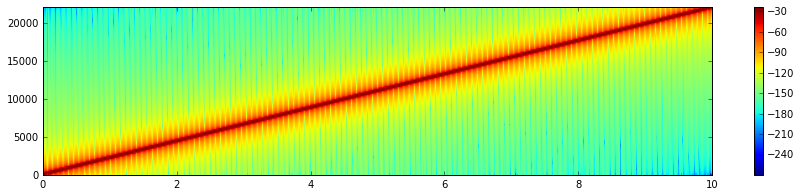

In [10]:
plt.figure(figsize=(15,3))
plt.specgram(w, Fs=44100)
plt.colorbar()
_=plt.axis((0,10,0,22050))
ipd.Audio('sine_sweep_44100.wav')

What you see above is a spectrogram of the sine sweep with time on the x-axis, frequency on the y-axis. By playing the actual audio file, you can easily guess what the spectrogram shows. 
It shows the spectrum of frequency over time. Since our sine sweep started from 20hz, you can see at the start the red line start low, then its pitch going up until it reaches 22.05khz.

What if we simply skip every other samples to reduce the sampling rate to half?

In [11]:
down_sampled = w[::2]
sf.write('sine_sweep_downsampled.wav', down_sampled, 22050)

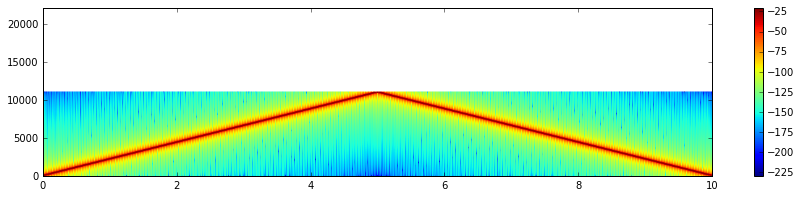

In [12]:
plt.figure(figsize=(15,3))
plt.specgram(down_sampled, Fs=22050)
plt.colorbar()
_=plt.axis((0,10,0,22050))
ipd.Audio('sine_sweep_downsampled.wav')

What just happened?? The pitch is not constantly increasing anymore, it increases then decreases. Only thing I did was skipping every other sample, but I didn't change anything else.

In order to explain what has happened, we need to understand the Nyquist Sampling Theorem. According to the Nyquist Theorem, half the sampling rate, the Nyquist limit, is the highest frequency component that can be accurately represented. So, in the signal with 22.05khz sampling rate, the highest frequency it can represent is 11.025khz, but our original sine sweep, frequency (pitch) increases up to 22.05khz, thus all those extra energies which cannot be represented with 22.05khz sampling rate (spectrum ranging from 11.025khz to 22.05khz) has gone into negative frequency and created decreasing sine sweep.

In this case, the signal first needs to be transformed by a low-pass filter, then every other sample should be selected. And depending on the ratio of two sample rates, it will even complicate things even more. Furthermore, in the case of upsampling, we might need to interpolate to get the samples which were not included in the original sampled signal.

The reason I went through the above example was to show you some caveats when you are dealing with digital signal data. But the purpose of this post is not to create a new package for sample rate conversion. Then what do we do? Luckily we already have a wonderful library called Librosa which does all the conversion for us, hooray! (The actual sample rate conversion part in Librosa is done by either Resampy by default or Scipy's resampling)

# Librosa

Now let's pick one file from our dataset, and load the same file both with Librosa and Scipy's Wave module and see how it differs.

In [67]:
data[data.slice_file_name == '100652-3-0-1.wav']

,slice_file_name,fsID,start,end,salience,fold,classID,class,n_channels,sampling_rate,bit_depth
15,100652-3-0-1.wav,100652,0.5,4.5,1,2,3,dog_bark,2,44100,16


By default, Librosa will convert the sampling rate to 22.05khz, as well as reducing the number of channels to 1(mono), and normalize the data so that the values will range from -1 to 1.

In [93]:
import librosa
fullpath,_ = path_class('100652-3-0-1.wav')
librosa_load, librosa_sampling_rate = librosa.load(fullpath)
scipy_sampling_rate, scipy_load = wav.read(fullpath)
print('original sample rate:',scipy_sampling_rate)
print('converted sample rate:',librosa_sampling_rate)
print('\n')
print('original wav file min~max range:',np.min(scipy_load),'~',np.max(scipy_load))
print('converted wav file min~max range:',np.min(librosa_load),'~',np.max(librosa_load))

original sample rate: 44100
converted sample rate: 22050


original wav file min~max range: -30926 ~ 30119
converted wav file min~max range: -0.729611 ~ 0.743313


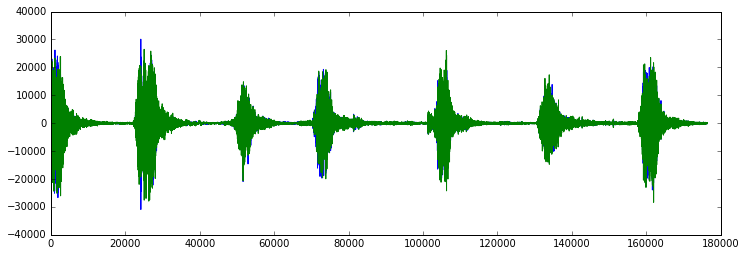

In [94]:
plt.figure(figsize=(12, 4))
plt.plot(scipy_load)

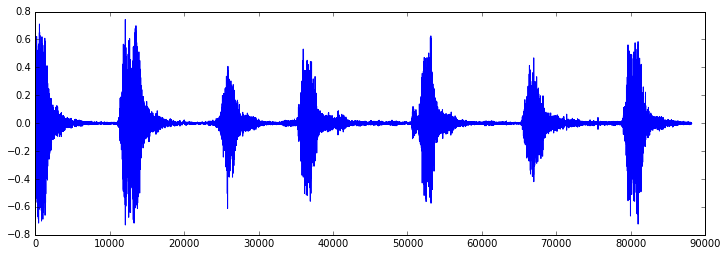

In [95]:
plt.figure(figsize=(12, 4))
plt.plot(librosa_load) 

By plotting two data loaded from the same source sound file, we can see that Librosa loaded data has been reduced to mono (only one colour line on the graph), while the original has two channels (green for one channel, and blue for the other).

And guess what. All the worries I had about each data having all different sampling rates, number of channels, different value ranges just been beautifully solved by loading sound data with Librosa!

I could have just used Librosa from the beginning, and not even worry about any of these different types of wave file format, but by investigating what Librosa is actually doing when loading a sound file, now I have a better understanding of different sound data types, what these mean.

I think I now have quite a good understanding of the data that I am dealing with and next is the fun part, machine learning. In the next post, I will finally start the first phase of model building: feature extraction.
